In [1]:
import tensorflow as tf
from src.functions import initializers as ci  # i.e., custom initalizers
from src.functions.layers import ActivLin1D  # import the custom activation function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.utils import data_handler as dh
from src.utils import plotter as pl
from train_forward_model import forward_training
from train_inverse_model import inverse_training

## Load forward training set

In [2]:
direct_dataset_path = '/Users/francescomaraschin/Desktop/IntelligentVehicles/LongitudinalControllerNN/Data/csv/forward_profiles.csv'
# Load data
direct_dataset = dh.load_csv(direct_dataset_path)

In [3]:
# Check for NaNs
direct_dataset.isnull().values.any()

False

In [4]:
# Replacing infinite with NaN
direct_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)

# Dropping all the rows with nan values
direct_dataset.dropna(inplace=True)

## Plot the dataset

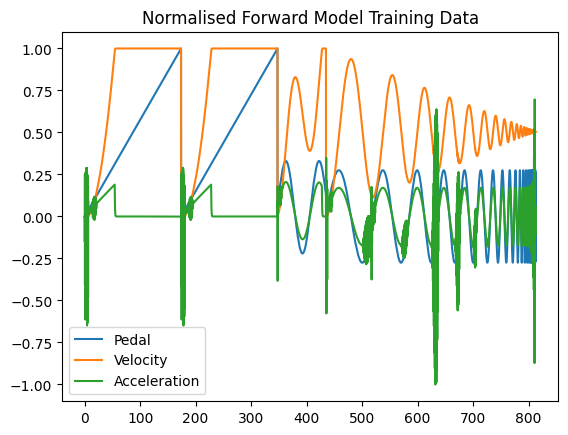

In [5]:
plt.plot(direct_dataset)
plt.title('Normalised Forward Model Training Data')
plt.legend(['Pedal' , 'Velocity' , 'Acceleration'])
plt.show()

## Train the forward model

In [6]:
[forward_model,
     forward_history,
     forward_train_data,
     forward_valid_data,
     time,
     batch_size] = forward_training(direct_dataset)

Metal device set to: Apple M1


2023-02-13 11:21:57.080808: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-13 11:21:57.081446: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-13 11:21:57.087321: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-02-13 11:21:57.095155: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-13 11:21:57.102721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:21:57.144557: I tensorflow/core/grappler/optimizers/custom_graph

Model: "custom_activation_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_vx (InputLayer)          [(100, 10)]          0           []                               
                                                                                                  
 tf_op_layer_strided_slice (Ten  [(100, 1)]          0           ['input_vx[0][0]']               
 sorFlowOpLayer)                                                                                  
                                                                                                  
 tf_op_layer_strided_slice_1 (T  [(100, 1)]          0           ['input_vx[0][0]']               
 ensorFlowOpLayer)                                                                                
                                                                            

2023-02-13 11:21:57.719164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:21:57.750589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:21:57.939237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11300/11300 [==============================] - ETA: 0s - loss: 0.0059

/Users/francescomaraschin/Desktop/IntelligentVehicles/LongitudinalControllerNN/NN_Python/venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-02-13 11:22:01.236571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.01301, saving model to /Users/francescomaraschin/Desktop/IntelligentVehicles/LongitudinalControllerNN/Data/trained_models/forward_model/forward_model.h5
11300/11300 [==============================] - 4s 385us/sample - loss: 0.0059 - val_loss: 0.0130
Epoch 2/100
  400/11300 [>.............................] - ETA: 2s - loss: 0.0027

2023-02-13 11:22:01.936443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:22:01.940342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:22:01.943827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:22:01.951946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:22:01.959704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:22:01.965306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:22:01.974963: I tensorflow/core/grappler/optimizers/cust

11100/11300 [============================>.] - ETA: 0s - loss: 0.0042
Epoch 2: val_loss improved from 0.01301 to 0.01280, saving model to /Users/francescomaraschin/Desktop/IntelligentVehicles/LongitudinalControllerNN/Data/trained_models/forward_model/forward_model.h5
11300/11300 [==============================] - 2s 171us/sample - loss: 0.0042 - val_loss: 0.0128
Epoch 3/100
11200/11300 [============================>.] - ETA: 0s - loss: 0.0041
Epoch 3: val_loss did not improve from 0.01280
11300/11300 [==============================] - 3s 232us/sample - loss: 0.0041 - val_loss: 0.0130
Epoch 4/100
11200/11300 [============================>.] - ETA: 0s - loss: 0.0041
Epoch 4: val_loss improved from 0.01280 to 0.01279, saving model to /Users/francescomaraschin/Desktop/IntelligentVehicles/LongitudinalControllerNN/Data/trained_models/forward_model/forward_model.h5
11300/11300 [==============================] - 5s 466us/sample - loss: 0.0041 - val_loss: 0.0128
Epoch 5/100
10900/11300 [=======

2023-02-13 11:25:45.719037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:25:45.740533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:25:45.763284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:25:45.874583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:25:45.900753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:25:45.924024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:25:45.986479: I tensorflow/core/grappler/optimizers/cust

## Plot the results

/Users/francescomaraschin/Desktop/IntelligentVehicles/LongitudinalControllerNN/NN_Python/venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-02-13 11:26:40.013351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


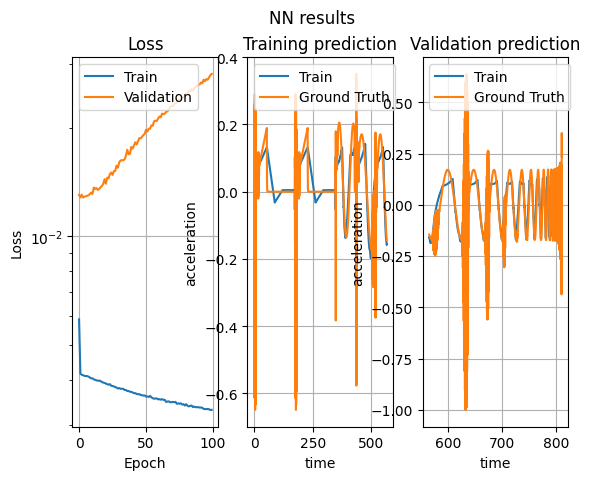

In [7]:
pl.results(model=forward_model,
               history=forward_history,
               dataset=[forward_train_data,
                        forward_valid_data],
               time=time,
               batch_size=batch_size)

## Calculate input for the inverse model

In [8]:
calculated_accelerations_1 = forward_model.predict(forward_train_data[0])
calculated_accelerations_2 = forward_model.predict(forward_valid_data[0])

calculated_accelerations = np.concatenate([calculated_accelerations_1 , calculated_accelerations_2])

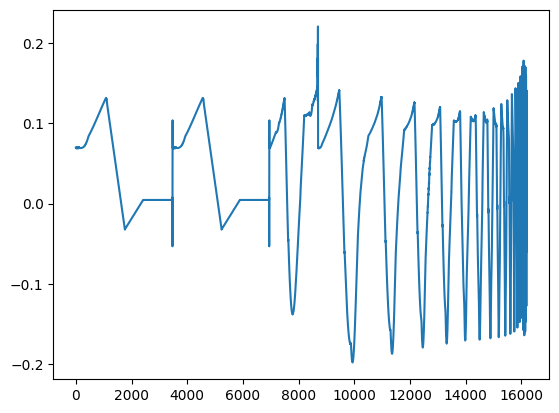

In [9]:
plt.plot(calculated_accelerations)

## Create input dataset for the inverse model

This data set should consist of the accelerations and the velocities

In [10]:
time = pd.read_csv(direct_dataset_path , usecols=['time'])
velocity = pd.read_csv(direct_dataset_path , usecols=['velocity'])
acceleration = pd.DataFrame(calculated_accelerations , columns= ['acceleration'])
pedal = pd.DataFrame(calculated_accelerations , columns= ['pedal'])

In [11]:
inverse_dataset = pd.concat([time , velocity, acceleration , pedal], axis=1)

# Replacing infinite with nan
inverse_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)

# Dropping all the rows with nan values
inverse_dataset.dropna(inplace=True)

# Save inverse dataset to csv to be used in the comparison between the py & C++ models:
pd.DataFrame(inverse_dataset).to_csv("/Users/francescomaraschin/Desktop/IntelligentVehicles/LongitudinalControllerNN/Data/csv/inverse_dataset.csv", header=['time','velocity','acceleration','pedal'], index=None)

inverse_dataset = inverse_dataset.set_index('time')

In [12]:
inverse_dataset

,velocity,acceleration,pedal
time,,,
0.00,-2.942667e-09,0.069530,0.069530
0.05,-2.276415e-08,0.069449,0.069449
0.10,2.092924e-08,0.069243,0.069243
0.15,-3.635123e-07,0.069377,0.069377
0.20,-6.353557e-06,0.069553,0.069553
...,...,...,...
809.75,4.994623e-01,-0.018955,-0.018955
809.80,5.027220e-01,-0.018953,-0.018953
809.85,5.060750e-01,-0.039552,-0.039552


## Train the inverse model

In [13]:
[inverse_model,
     inv_history,
     inv_train_data,
     inv_valid_data,
     time,
     batch_size] = inverse_training(inverse_dataset = inverse_dataset)

2023-02-13 11:27:00.645685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:27:00.668456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:27:00.685931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:27:00.704560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:27:00.721141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:27:00.737728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:27:00.876697: I tensorflow/core/grappler/optimizers/cust

Model: "inverse_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_vx (InputLayer)          [(100, 10)]          0           []                               
                                                                                                  
 input_acc (InputLayer)         [(100, 10)]          0           []                               
                                                                                                  
 activated_acceleration_0 (Acti  (100, 10)           0           ['input_vx[0][0]',               
 vLin1D)                                                          'input_acc[0][0]']              
                                                                                                  
 activated_acceleration_1 (Acti  (100, 10)           0           ['input_vx[0][0]',   

2023-02-13 11:27:01.091892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:27:01.114824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:27:01.139796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train on 11200 samples, validate on 4900 samples
Epoch 1/100


2023-02-13 11:27:01.450140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:27:01.491647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:27:01.516540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11200/11200 [==============================] - ETA: 0s - loss: 0.0012

/Users/francescomaraschin/Desktop/IntelligentVehicles/LongitudinalControllerNN/NN_Python/venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-02-13 11:27:03.457767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.00164, saving model to /Users/francescomaraschin/Desktop/IntelligentVehicles/LongitudinalControllerNN/Data/trained_models/inverse_model/inverse_model.h5


2023-02-13 11:27:04.232866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:27:04.312156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:27:04.326580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:27:04.345799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:27:04.376319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:27:04.397208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:27:04.417529: I tensorflow/core/grappler/optimizers/cust

11200/11200 [==============================] - 3s 292us/sample - loss: 0.0012 - val_loss: 0.0016
Epoch 2/100
10900/11200 [============================>.] - ETA: 0s - loss: 3.0126e-04
Epoch 2: val_loss improved from 0.00164 to 0.00151, saving model to /Users/francescomaraschin/Desktop/IntelligentVehicles/LongitudinalControllerNN/Data/trained_models/inverse_model/inverse_model.h5
11200/11200 [==============================] - 3s 233us/sample - loss: 2.9960e-04 - val_loss: 0.0015
Epoch 3/100
11200/11200 [==============================] - ETA: 0s - loss: 2.8330e-04
Epoch 3: val_loss improved from 0.00151 to 0.00143, saving model to /Users/francescomaraschin/Desktop/IntelligentVehicles/LongitudinalControllerNN/Data/trained_models/inverse_model/inverse_model.h5
11200/11200 [==============================] - 3s 266us/sample - loss: 2.8330e-04 - val_loss: 0.0014
Epoch 4/100
10800/11200 [===========================>..] - ETA: 0s - loss: 2.7139e-04
Epoch 4: val_loss did not improve from 0.00143


2023-02-13 11:30:14.069824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:30:14.118367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:30:14.165353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:30:14.298292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:30:14.345114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:30:14.379039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 11:30:14.453666: I tensorflow/core/grappler/optimizers/cust

/Users/francescomaraschin/Desktop/IntelligentVehicles/LongitudinalControllerNN/NN_Python/venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-02-13 11:39:09.509228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


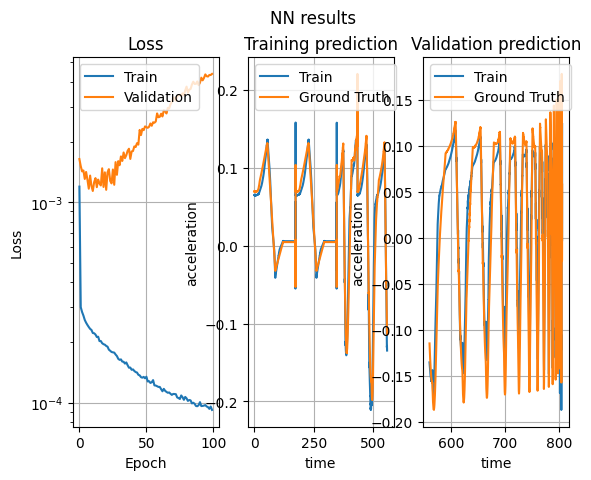

In [14]:
pl.results(model=inverse_model,
               history=inv_history,
               dataset=[inv_train_data,
                        inv_valid_data],
               time=time,
               batch_size=batch_size)

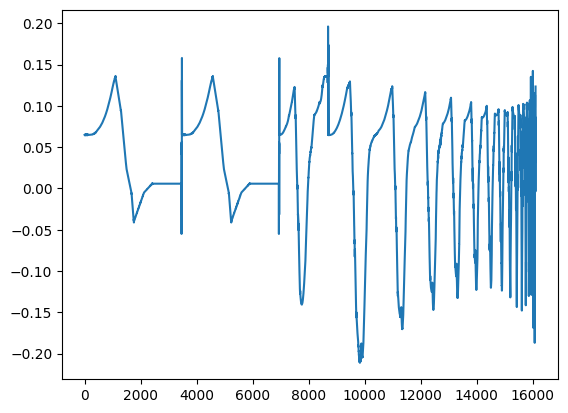

In [15]:
calculated_pedal_1 = inverse_model.predict(inv_train_data[0])
calculated_pedal_2 = inverse_model.predict(inv_valid_data[0])

calculated_pedal = np.concatenate([calculated_pedal_1 , calculated_pedal_2])

plt.plot(calculated_pedal)